In [ ]:
import pickle
import numpy as np

from utils import load_data, generate_data, preprocess_data, error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from pydmd import DMD, DMDc

import matplotlib.pyplot as plt
from pylc.utils import format_axis, rcparams, format_axis_im
from mpl_toolkits.axes_grid1 import make_axes_locatable
rcparams(1)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

### load data

In [ ]:
x, u, sites = load_data(holiday=False, pollutant=['SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3'])

x = preprocess_data(x)
u = preprocess_data(u)

x, u = generate_data(x, u, window=4*24, size=31*24, rolling=True)

print([x.shape, u.shape])

### simple dmd

In [ ]:
def dmd(x, r, n_pca=None, return_A=True):
    
    ss = StandardScaler()
    x_ = ss.fit_transform(x.T).T
    
    if n_pca != None:
        pca = PCA(n_components=n_pca, whiten=True, random_state=0)
        x_ = pca.fit_transform(x_.T).T
    
    # x: m*n, m > n-1 is the often case in DMD
    # r_max = min(m, n-1)
    dmd_ = DMD(svd_rank=r)
    dmd_.fit(x_)
    x_pred = dmd_.reconstructed_data.real

    if n_pca != None:
        x_pred = pca.inverse_transform(x_pred.T).T
    
    x_pred = ss.inverse_transform(x_pred.T).T
    
    if return_A:
        return x_pred, dmd_.eigs
    else:
        return x_pred

In [ ]:
x_pred, A_ = dmd(x[284], r=84, n_pca=85)

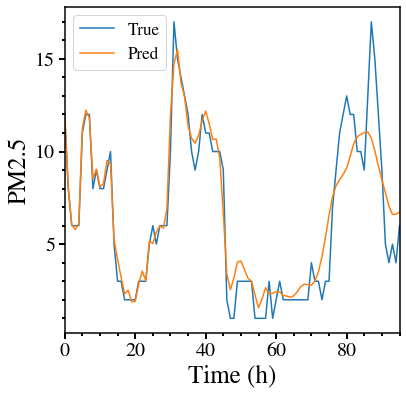

In [838]:
fig, ax = plt.subplots()

ax.plot(x[284][0], label='True')
ax.plot(x_pred[0], label='Pred')

ax.set_xlabel('Time (h)')
ax.set_ylabel('PM2.5')
ax.set_xlim([0, 95])
ax.legend()
format_axis(ax)

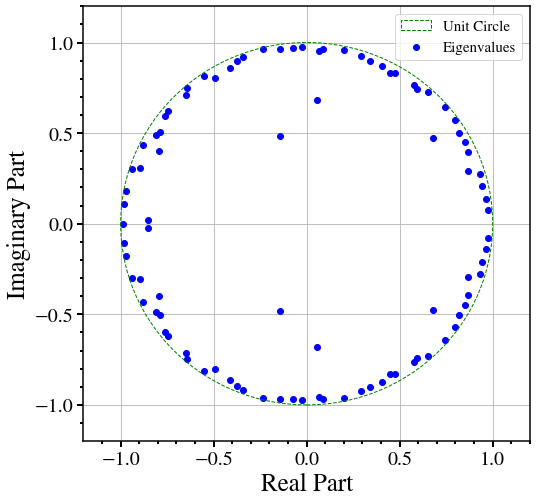

In [760]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(A_.real, A_.imag, color='b', label='Eigenvalues')
circle = plt.Circle((0, 0), 1, edgecolor='g', linestyle='--', fill=False, label='Unit Circle')
ax.add_patch(circle)
ax.legend(loc=1, fontsize=15)
ax.grid()
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
format_axis(ax)
# plt.savefig('../result/figure/A1_eig.png', dpi=300, bbox_inches='tight')

### dmd with control

In [4]:
def dmdc(x, u, r, n_pca=None, std=True):
    
    u = u[:, :-1]
    
    if std == True:
        ss = StandardScaler()
        x_ = ss.fit_transform(x.T).T

        ss1 = StandardScaler()
        u_ = ss1.fit_transform(u.T).T
    else:
        x_ = x
        u_ = u
    
    if n_pca != None:
        pca = PCA(n_components=n_pca, whiten=True, random_state=0)
        x_ = pca.fit_transform(x_.T).T
        
        pca2 = PCA(n_components=n_pca, whiten=True, random_state=1)
        u_ = pca2.fit_transform(u_.T).T
    
    # x: m*n, m > n-1 is the often case in DMD
    # r_max = min(m, n-1)
    dmd_ = DMDc(svd_rank=r)
    dmd_.fit(x_, u_)
    x_pred = dmd_.reconstructed_data().real

    if n_pca != None:
        x_pred = pca.inverse_transform(x_pred.T).T
    
    if std == True:
        x_pred = ss.inverse_transform(x_pred.T).T
    else:
        x_pred = x_pred
    
    return x_pred, dmd_.B

In [54]:
i = 0
x_pred, B_ = dmdc(x[i], u[i], r=90, n_pca=None, std=True)

B = np.array(B_)
# err1_ = error(x[-1], x_pred, mode='percent')

In [7]:
ss1 = StandardScaler()
x_ = ss1.fit_transform(x[0].T).T

Text(-2, 187, 'O$_3$')

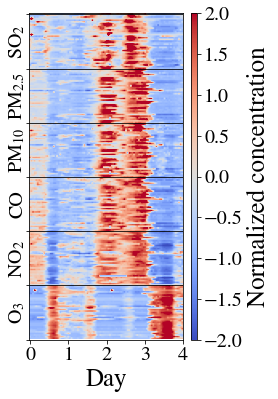

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(x_, cmap='coolwarm', vmin=-2, vmax=2)
ax.set_xticks([24 * i for i in range(5)])
ax.set_yticks([34 * i for i in range(7)])
ax.set_yticklabels([])
ax.set_xticklabels([0, 1, 2, 3, 4])
ax.grid(c='k', axis='y')
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="4%", pad="5%")
cb = fig.colorbar(im, cax=cax)
cb.set_label(label='Normalized concentration', size=25)
ax.set_xlabel('Day')

ax.text(-2, 17, r'SO$_2$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 51, r'PM$_{2.5}$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 85, r'PM$_{10}$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 119, r'CO', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 153, r'NO$_2$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 187, r'O$_3$', va='center', ha='right', rotation=90, fontsize=20)


Text(187, -15, 'O$_3$')

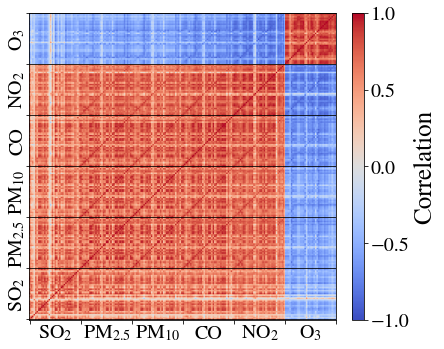

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(np.corrcoef(x_), cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
ax.set_xticks([34 * i for i in range(7)])
ax.set_yticks([34 * i for i in range(7)])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(c='k', axis='y')
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="4%", pad="5%")
cb = fig.colorbar(im, cax=cax)
cb.set_label(label='Correlation', size=25)


ax.text(-2, 17, r'SO$_2$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 51, r'PM$_{2.5}$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 85, r'PM$_{10}$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 119, r'CO', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 153, r'NO$_2$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 187, r'O$_3$', va='center', ha='right', rotation=90, fontsize=20)

ax.text(17, -15, r'SO$_2$', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(51, -15, r'PM$_{2.5}$', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(85, -15, r'PM$_{10}$', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(119, -15, r'CO', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(153, -15, r'NO$_2$', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(187, -15, r'O$_3$', va='bottom', ha='center', rotation=0, fontsize=20)


In [831]:
ss1 = StandardScaler()
u_ = ss1.fit_transform(u[0].T).T

Text(-2, 221, 'blh')

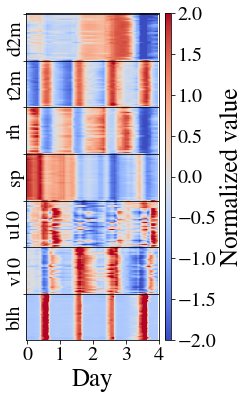

In [835]:
fig, ax = plt.subplots()
im = ax.imshow(u_, cmap='coolwarm', vmin=-2, vmax=2)
ax.set_xticks([24 * i for i in range(5)])
ax.set_yticks([34 * i for i in range(7)])
ax.set_yticklabels([])
ax.set_xticklabels([0, 1, 2, 3, 4])
ax.grid(c='k', axis='y')
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="4%", pad="5%")
cb = fig.colorbar(im, cax=cax)
cb.set_label(label='Normalized value', size=25)
ax.set_xlabel('Day')

ax.text(-2, 17, r'd2m', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 51, r't2m', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 85, r'rh', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 119, r'sp', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 153, r'u10', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 187, r'v10', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 221, r'blh', va='center', ha='right', rotation=90, fontsize=20)

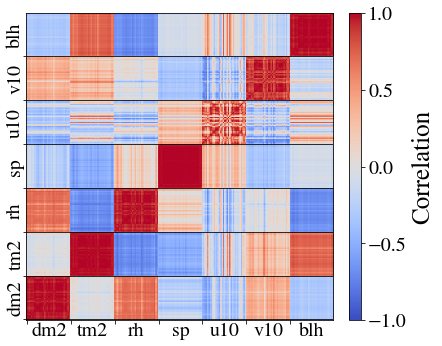

In [846]:
fig, ax = plt.subplots()
im = ax.imshow(np.corrcoef(u_), cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
ax.set_xticks([34 * i for i in range(7)])
ax.set_yticks([34 * i for i in range(7)])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(c='k', axis='y')
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="4%", pad="5%")
cb = fig.colorbar(im, cax=cax)
cb.set_label(label='Correlation', size=25)


ax.text(-2, 17, r'dm2', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 51, r'tm2', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 85, r'rh', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 119, r'sp', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 153, r'u10', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 187, r'v10', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 221, r'blh', va='center', ha='right', rotation=90, fontsize=20)

ax.text(17, -15, r'dm2', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(51, -15, r'tm2', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(85, -15, r'rh', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(119, -15, r'sp', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(153, -15, r'u10', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(187, -15, r'v10', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(221, -15, r'blh', va='bottom', ha='center', rotation=0, fontsize=20);


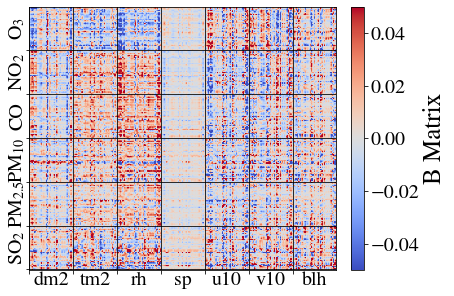

In [55]:
fig, ax = plt.subplots()
im = ax.imshow(B, cmap='coolwarm', vmin=-.05, vmax=.05, origin='lower')
ax.set_xticks([34 * i for i in range(7)])
ax.set_yticks([34 * i for i in range(6)])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(c='k', axis='both')
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="4%", pad="5%")
cb = fig.colorbar(im, cax=cax)
cb.set_label(label='B Matrix', size=25)


ax.text(-2, 17, r'SO$_2$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 51, r'PM$_{2.5}$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 85, r'PM$_{10}$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 119, r'CO', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 153, r'NO$_2$', va='center', ha='right', rotation=90, fontsize=20)
ax.text(-2, 187, r'O$_3$', va='center', ha='right', rotation=90, fontsize=20)

ax.text(17, -15, r'dm2', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(51, -15, r'tm2', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(85, -15, r'rh', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(119, -15, r'sp', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(153, -15, r'u10', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(187, -15, r'v10', va='bottom', ha='center', rotation=0, fontsize=20)
ax.text(221, -15, r'blh', va='bottom', ha='center', rotation=0, fontsize=20);


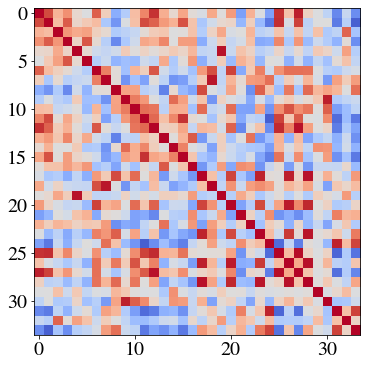

In [87]:
i = 0
j = 5

Bs = B[i*34:(i+1)*34, j*34:(j+1)*34]
Bc = np.corrcoef(Bs.T)
plt.imshow(Bc, cmap='coolwarm', vmin=-1, vmax=1)

In [49]:
downtown = ['FTHY', 'WL', 'XZMB', 'GY', 'WSXG', 'NSH', 'YDMN', 'QM', 'ATZX', 'DS', 'TT', 'NZG', 'DSH']
suburban = ['BBXQ', 'MTG', 'GC', 'YG', 'FS', 'DX', 'YZ', 'TZ']
northwest_rural = ['YQ', 'BDL', 'DL', 'CP']
northeast_rural = ['SY', 'HR', 'MY', 'SK', 'PG', 'DGC']
southwest_rural = ['LLH']
southeast_rural = ['YF', 'YLD']

In [50]:
downtown_idx = [np.where(sites == downtown[i])[0][0] for i in range(len(downtown))]
suburban_idx = [np.where(sites == suburban[i])[0][0] for i in range(len(suburban))]
northwest_rural_idx = [np.where(sites == northwest_rural[i])[0][0] for i in range(len(northwest_rural))]
northeast_rural_idx = [np.where(sites == northeast_rural[i])[0][0] for i in range(len(northeast_rural))]
southwest_rural_idx = [np.where(sites == southwest_rural[i])[0][0] for i in range(len(southwest_rural))]
southeast_rural_idx = [np.where(sites == southeast_rural[i])[0][0] for i in range(len(southeast_rural))]

len(downtown_idx), len(suburban_idx), len(northwest_rural_idx), len(northeast_rural_idx), len(southwest_rural_idx), len(southeast_rural_idx)

(13, 8, 4, 6, 1, 2)

In [51]:
idx = downtown_idx + suburban_idx + northwest_rural_idx + northeast_rural_idx + southwest_rural_idx + southeast_rural_idx

In [88]:
c1 = Bc[idx]
c2 = c1[:, idx]

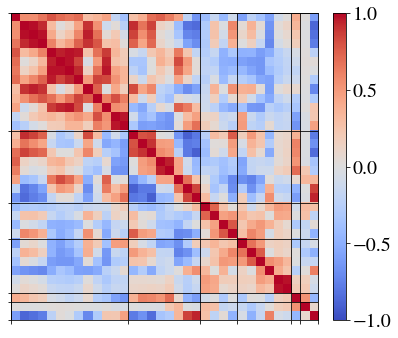

In [89]:
fig, ax = plt.subplots()
im = ax.imshow(c2, cmap='coolwarm', vmin=-1, vmax=1)

ax.set_xticks([-0.5, 12.5, 20.5, 24.5, 30.5, 31.5, 33.5])
ax.set_yticks([-0.5, 12.5, 20.5, 24.5, 30.5, 31.5, 33.5])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

div = make_axes_locatable(ax)
cax = div.append_axes("right", size="4%", pad="5%")
cb = fig.colorbar(im, cax=cax)

# format_axis_im(ax)
# plt.yticks([12.5, 20.5, 24.5, 30.5, 33.5])
ax.grid(c='k')

In [500]:
len(idx1)

204

### dmd without pca

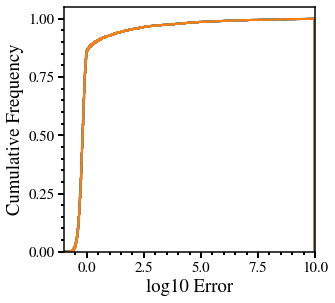

In [60]:
n_bins = np.arange(-1.0, 10.0, 0.01)
fig, ax = plt.subplots()

for i in np.arange(1, 56+1, 5):
    with open(f'../result/pickle/pca_56_r_{i}_simple.pickle', 'rb') as handle:
        err = pickle.load(handle)
    err_ = err[:, 0]
    n, bins, patches = ax.hist(np.log10(err_), n_bins, density=True, histtype='step',
                               cumulative=True, label='PCA', linewidth=2)
ax.set_xlim([-1, 10])
# ax.legend(loc=4)

ax.set_xlabel('log10 Error')
ax.set_ylabel('Cumulative Frequency')
format_axis(ax)

In [61]:
with open(f'../result/pickle/pca_56_r_1_simple.pickle', 'rb') as handle:
    err = pickle.load(handle)
err[:, 0]

array([0.57023229, 0.51061473, 6.77013973, ..., 0.27828644, 0.3223044 ,
       1.35845081])

In [62]:
with open(f'../result/pickle/pca_56_r_6_simple.pickle', 'rb') as handle:
    err = pickle.load(handle)
err[:, 0]

array([0.57023229, 0.51061473, 6.77013973, ..., 0.27828644, 0.3223044 ,
       1.35845081])

In [54]:
i = 372
x_true1, x_pred1, x_forecast1, x_future1, cond1_, eig1_ = dmd(x[i], x[i+24], r=85, n_pca=86)
x_true2, x_pred2, x_forecast2, x_future2, cond2_, eig2_ = dmd(x[i], x[i+24], r=85, n_pca=None)

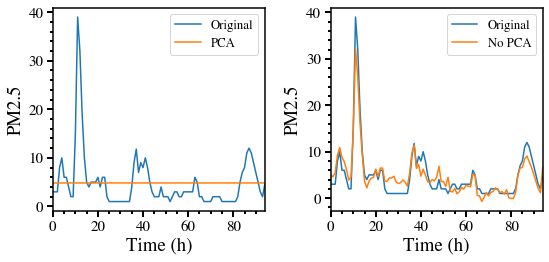

In [95]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2)
ax[0].plot(x_true1[1], label='Original')
ax[0].plot(x_pred1[1], label='PCA')

ax[1].plot(x_true1[1], label='Original')
ax[1].plot(x_pred2[1], label='No PCA')

for ax_ in ax:
    ax_.set_xlabel('Time (h)')
    ax_.set_ylabel('PM2.5')
    ax_.set_xlim([0, 94])
    ax_.legend()
    format_axis(ax_)
plt.tight_layout()
plt.savefig('../result/figure/pca_worst.png', dpi=300, bbox_inches='tight')

In [78]:
i = 372
x_true1, x_pred1, x_forecast1, x_future1, cond1_, eig1_ = dmd(x[i], x[i+24], r=57, n_pca=None)
x_true2, x_pred2, x_forecast2, x_future2, cond2_, eig2_ = dmd(x[i], x[i+24], r=58, n_pca=None)
x_true3, x_pred3, x_forecast3, x_future3, cond3_, eig3_ = dmd(x[i], x[i+24], r=85, n_pca=None)

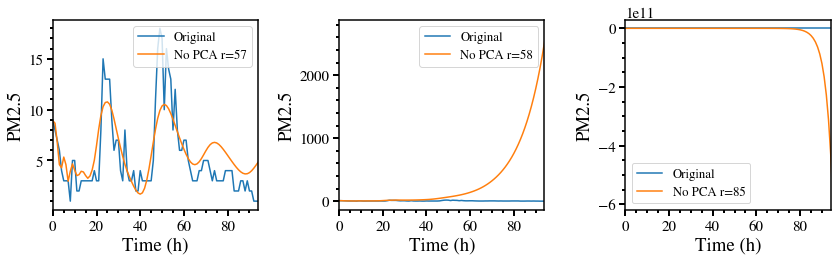

In [79]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
ax[0].plot(x_true1[1], label='Original')
ax[0].plot(x_pred1[1], label='No PCA r=57')

ax[1].plot(x_true1[1], label='Original')
ax[1].plot(x_pred2[1], label='No PCA r=58')

ax[2].plot(x_true1[1], label='Original')
ax[2].plot(x_pred3[1], label='No PCA r=85')

for ax_ in ax:
    ax_.set_xlabel('Time (h)')
    ax_.set_ylabel('PM2.5')
    ax_.set_xlim([0, 94])
    ax_.legend()
    format_axis(ax_)
plt.tight_layout()
plt.savefig('../result/figure/pca_worst_nochange.png', dpi=300, bbox_inches='tight')

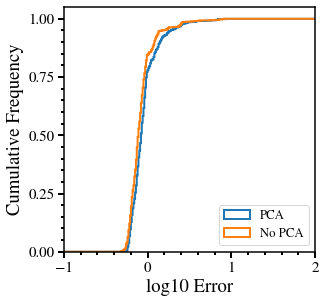

In [82]:
n_bins = np.arange(-1.0, 10.0, 0.01)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(erf1), n_bins, density=True, histtype='step',
                           cumulative=True, label='PCA', linewidth=2)
n, bins, patches = ax.hist(np.log10(erf2), n_bins, density=True, histtype='step',
                           cumulative=True, label='No PCA', linewidth=2)
ax.set_xlim([-1, 2])
ax.legend(loc=4)

ax.set_xlabel('log10 Error')
ax.set_ylabel('Cumulative Frequency')
format_axis(ax)
plt.savefig('../result/figure/error_forecast.png', dpi=300, bbox_inches='tight')

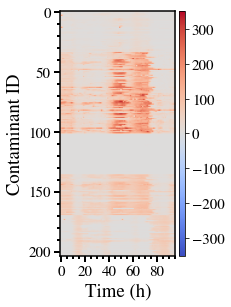

1027.5057058480543


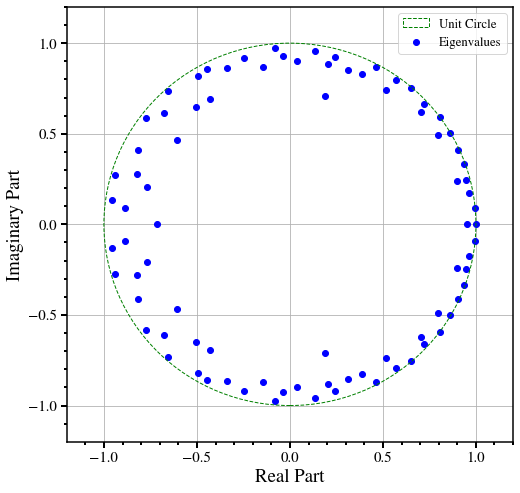

In [32]:
x_ = x[0]
xmax_ = np.max([x_.max(), np.abs(x_.min())])
fig, ax = plt.subplots()
im = ax.imshow(x_, vmin=-xmax_, vmax=xmax_, cmap='coolwarm')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel('Time (h)')
ax.set_ylabel('Contaminant ID')
format_axis(ax)

plt.savefig('../result/figure/cond_original.png', dpi=300, bbox_inches='tight')
plt.show()

dmd_ = DMD(svd_rank=85)
dmd_.fit(x_)
A_ = dmd_.eigs

print(np.linalg.cond(x_))

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(A_.real, A_.imag, color='b', label='Eigenvalues')
circle = plt.Circle((0, 0), 1, edgecolor='g', linestyle='--', fill=False, label='Unit Circle')
ax.add_patch(circle)
ax.legend(loc=1)
ax.grid()
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
format_axis(ax)
plt.savefig('../result/figure/A1_eig.png', dpi=300, bbox_inches='tight')

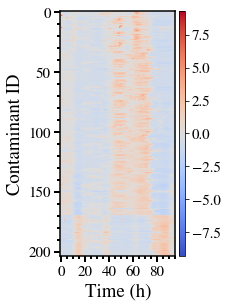

9516916868402182.0
41.63072229582009


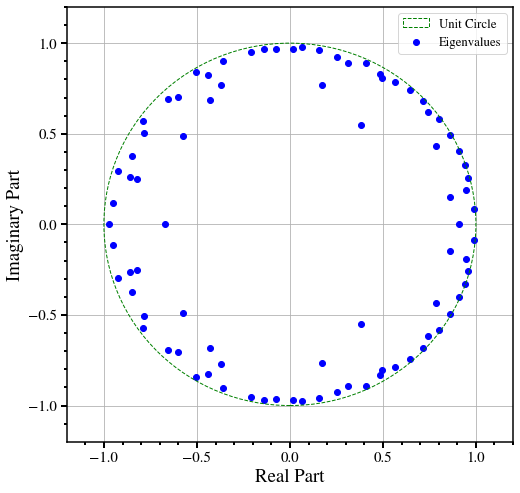

In [33]:
ss = StandardScaler()
x_ = ss.fit_transform(x_.T).T

xmax_ = np.max([x_.max(), np.abs(x_.min())])
fig, ax = plt.subplots()
im = ax.imshow(x_, vmin=-xmax_, vmax=xmax_, cmap='coolwarm')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel('Time (h)')
ax.set_ylabel('Contaminant ID')
format_axis(ax)

plt.savefig('../result/figure/cond_original.png', dpi=300, bbox_inches='tight')
plt.show()
print(np.linalg.cond(x_))
print(np.linalg.svd(x_)[1][1])

dmd_ = DMD(svd_rank=85)
dmd_.fit(x_)
A2_ = dmd_.eigs

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(A2_.real, A2_.imag, color='b', label='Eigenvalues')
circle = plt.Circle((0, 0), 1, edgecolor='g', linestyle='--', fill=False, label='Unit Circle')
ax.add_patch(circle)
ax.legend(loc=1)
ax.grid()
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
format_axis(ax)
plt.savefig('../result/figure/A2_eig.png', dpi=300, bbox_inches='tight')

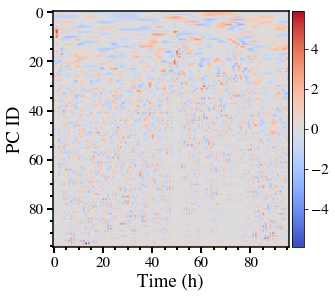

1.0000000000000013
9.746794344808977


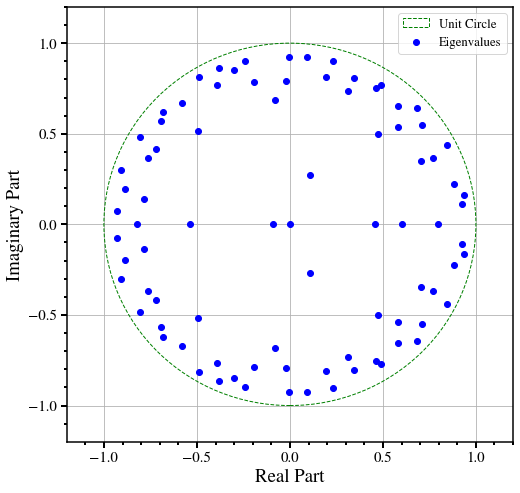

In [34]:
pca = PCA(n_components=96, whiten=True, random_state=0)
x_ = pca.fit_transform(x_.T).T

xmax_ = np.max([x_.max(), np.abs(x_.min())])
fig, ax = plt.subplots()
im = ax.imshow(x_, vmin=-xmax_, vmax=xmax_, cmap='coolwarm')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel('Time (h)')
ax.set_ylabel('PC ID')
format_axis(ax)

plt.savefig('../result/figure/cond_pca.png', dpi=300, bbox_inches='tight')
plt.show()
print(np.linalg.cond(x_))
print(np.linalg.svd(x_)[1][1])

dmd_ = DMD(svd_rank=85)
dmd_.fit(x_)
A3_ = dmd_.eigs

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(A3_.real, A3_.imag, color='b', label='Eigenvalues')
circle = plt.Circle((0, 0), 1, edgecolor='g', linestyle='--', fill=False, label='Unit Circle')
ax.add_patch(circle)
ax.legend(loc=1)
ax.grid()
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
format_axis(ax)
plt.savefig('../result/figure/A3_eig.png', dpi=300, bbox_inches='tight')

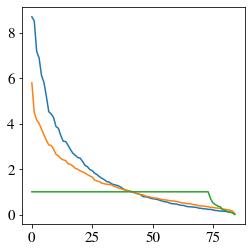

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.linalg.svd(A_)[1])
ax.plot(np.linalg.svd(A2_)[1])
ax.plot(np.linalg.svd(A3_)[1])

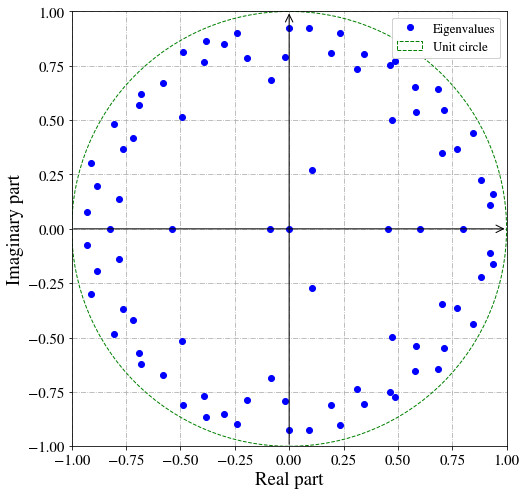

TypeError: 'numpy.float64' object is not iterable

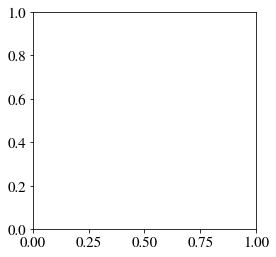

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(sorted(np.abs(np.linalg.norm(A_)), reverse=True), label='Original')
ax.plot(sorted(np.abs(np.linalg.norm(A2_)), reverse=True), label='After Std')
ax.plot(sorted(np.abs(np.linalg.norm(A3_)), reverse=True), label='After PCA')

ax.set_xlim([0, 85])
ax.set_xlabel('Index')
ax.set_ylabel('Eigenvalue')

ax.legend()
format_axis(ax)

plt.savefig('../result/figure/eig_comp.png', dpi=300, bbox_inches='tight')

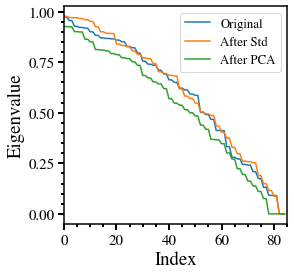

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(sorted(np.abs(np.linalg.eigvals(A_).imag), reverse=True), label='Original')
ax.plot(sorted(np.abs(np.linalg.eigvals(A2_).imag), reverse=True), label='After Std')
ax.plot(sorted(np.abs(np.linalg.eigvals(A3_).imag), reverse=True), label='After PCA')

ax.set_xlim([0, 85])
ax.set_xlabel('Index')
ax.set_ylabel('Eigenvalue')

ax.legend()
format_axis(ax)

plt.savefig('../result/figure/eig_comp.png', dpi=300, bbox_inches='tight')

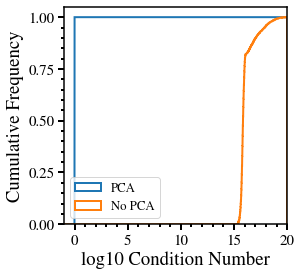

In [90]:
n_bins = np.arange(-1.0, 20.0, 0.01)

fig, ax = plt.subplots(figsize=(4, 4))
n, bins, patches = ax.hist(np.log10(cond1), n_bins, density=True, histtype='step',
                           cumulative=True, label='PCA', linewidth=2)
n, bins, patches = ax.hist(np.log10(cond2), n_bins, density=True, histtype='step',
                           cumulative=True, label='No PCA', linewidth=2)
ax.set_xlim([-1, 20])
ax.legend(loc=3)
format_axis(ax)

ax.set_xlabel('log10 Condition Number')
ax.set_ylabel('Cumulative Frequency')
format_axis(ax)
plt.savefig('../result/figure/cond.png', dpi=300, bbox_inches='tight')

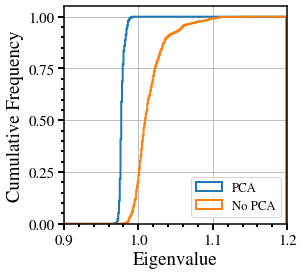

In [41]:
n_bins = np.arange(0.0, 1.2, 0.001)

fig, ax = plt.subplots(figsize=(4, 4))
n, bins, patches = ax.hist(eig1, n_bins, density=True, histtype='step',
                           cumulative=True, label='PCA', linewidth=2)
n, bins, patches = ax.hist(eig2, n_bins, density=True, histtype='step',
                           cumulative=True, label='No PCA', linewidth=2)
ax.set_xlim([0.9, 1.2])
ax.legend(loc=4)
ax.grid()
format_axis(ax)

ax.set_xlabel('Eigenvalue')
ax.set_ylabel('Cumulative Frequency')
format_axis(ax)
plt.savefig('../result/figure/eig.png', dpi=300, bbox_inches='tight')

In [49]:
np.where(np.array(eig1 ) >= 1), len(np.where(np.array(eig2) >= 1)[0]) / len(eig2)

((array([], dtype=int64),), 0.7970430107526881)

In [48]:
eig2

[0.9976886668219949,
 1.000860426526723,
 1.055662007075679,
 1.0773422414654692,
 1.0709265020313008,
 0.9952036042644639,
 1.0023596936927817,
 1.0041743771866682,
 1.0053090289972064,
 1.0018071429907236,
 0.9958038375275654,
 1.00709097362827,
 0.9981274932960742,
 0.9976290594096854,
 1.000441599381211,
 0.9921246732083799,
 0.9938313165734866,
 1.0052800323562625,
 1.0085286334390802,
 1.0026709590931895,
 1.0104650043795098,
 1.0195642992053913,
 1.0082220633712469,
 0.9976808258710502,
 1.0009197564714603,
 1.0077803794405638,
 1.003097692414519,
 0.9985131295482932,
 0.9929379771080157,
 0.9907773100569587,
 1.0865111262847866,
 1.001222512232601,
 1.019986284401742,
 1.0086829255865268,
 1.0022468569047698,
 1.0185451442398896,
 1.0208105653096806,
 1.111084677879896,
 1.0282062089360242,
 1.0027967588534363,
 1.022614258980674,
 1.0562542662247698,
 1.0167517457829136,
 1.020373744873037,
 1.0525142221256745,
 1.006885728310475,
 1.0005070379714631,
 1.0169960971714707,
 1.0

In [88]:
np.sum(np.array(err1) > np.array(err2))

245

In [97]:
np.log10(cond2)

array([15.97849628, 15.9701208 , 15.96314229, 15.93615052, 15.97350113,
       15.95650371, 15.9812645 , 15.98756217, 15.97456058, 15.97024854,
       15.97737215, 16.03525926, 15.99333178, 16.02474821, 16.05598451,
       16.02404952, 15.94077573, 16.00851958, 16.04187514, 16.00109266,
       15.94908955, 15.98182476, 16.02760438, 16.01508321, 15.96677435,
       15.96856017, 15.99404895, 16.00999049, 15.97801057, 15.99402338,
       15.93298011, 15.92769893, 15.95500186, 16.0299363 , 16.0065243 ,
       15.95375379, 15.98557874, 16.05668895, 15.97146605, 15.98670476,
       15.98250457, 16.03087337, 16.00893284, 15.93460097, 15.98549626,
       15.98362696, 16.01298805, 15.97431836, 16.01459754, 15.97083009,
       15.99192586, 15.98212004, 16.03996645, 15.9596874 , 16.00690248,
       16.00256275, 16.02708869, 16.04916055, 15.99578645, 15.9726799 ,
       16.02748221, 15.99472476, 15.99571337, 16.03903277, 15.96045961,
       16.03801897, 16.00159746, 16.02515158, 15.99646329, 16.00

In [148]:
x_true, x_pred, x_forecast, cond_ = dmd(x[0], r=85, n_pca=86)

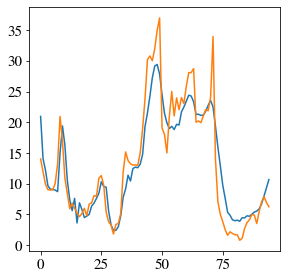

In [149]:
plt.plot(x_pred[0])
plt.plot(x_true[0])

In [327]:
dmd.eigs

array([-0.98909641+0.j        , -0.96934407+0.09568938j,
       -0.96934407-0.09568938j, -0.94392163+0.28110632j,
       -0.94392163-0.28110632j, -0.91285271+0.36132841j,
       -0.91285271-0.36132841j, -0.93214094+0.15327433j,
       -0.93214094-0.15327433j, -0.84489108+0.51079862j,
       -0.84489108-0.51079862j, -0.8027308 +0.57730197j,
       -0.8027308 -0.57730197j, -0.82051701+0.44470484j,
       -0.82051701-0.44470484j, -0.65026566+0.78729405j,
       -0.65026566-0.78729405j, -0.74963843+0.63346788j,
       -0.74963843-0.63346788j, -0.81682696+0.18244878j,
       -0.81682696-0.18244878j, -0.69765038+0.67958121j,
       -0.69765038-0.67958121j, -0.52899273+0.84326046j,
       -0.52899273-0.84326046j, -0.37417235+0.91301396j,
       -0.37417235-0.91301396j, -0.43455794+0.84943625j,
       -0.43455794-0.84943625j, -0.2700518 +0.97389671j,
       -0.2700518 -0.97389671j, -0.15283486+1.01635323j,
       -0.15283486-1.01635323j, -0.31725171+0.86763781j,
       -0.31725171-0.86763781j,

In [321]:
def train(size):
    x_in = layers.Input(shape=(204, ))
    x = layers.Dense(size, activation='selu')(x_in)
    x = layers.Dense(204, activation='sigmoid')(x)
    model = Model(inputs=x_in, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    cp = ModelCheckpoint(f'test_{size}.h5', monitor='val_loss',
                     verbose=0, save_best_only=True,
                     mode='min')
    els = EarlyStopping(monitor='val_loss', mode='min', patience=20)
    
    history = model.fit(x_train, x_train, batch_size=128,
                        epochs=500, callbacks=[cp, els],
                        validation_split=0.2, verbose=0, shuffle=True).history

In [80]:
n_components = np.arange(204, 150, -4)
for size in n_components:
    train(size)

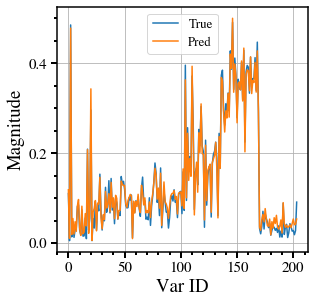

In [45]:
fig, ax = plt.subplots()
ax.plot(x_train[-2], label='True')
ax.plot(x_pred[-2], label='Pred')
ax.set_xlabel('Var ID')
ax.set_ylabel('Magnitude')
ax.legend()
ax.grid()
format_axis(ax)
plt.savefig('encoder.png', bbox_inches='tight', dpi=300)

In [81]:
from tensorflow import keras
def test(size):
    x_in = layers.Input(shape=(204, ))
    x = layers.Dense(size, activation='selu')(x_in)
    x = layers.Dense(204, activation='sigmoid')(x)
    model = Model(inputs=x_in, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.load_weights(f'test_{size}.h5')
    
    encoder = Model(model.input, model.layers[-2].output)

    decoder_input = layers.Input(shape=(size,))
    decoder = Model(decoder_input, model.layers[-1](decoder_input))

    
    xp = encoder.predict(xs)
    x = generate_data(xp.T, window=48)
    xp2 = xs
    x2 = generate_data(xp2.T, window=48)

    r = int(0.9*x.shape[-1])

    err, err2 = [], []

    for t in range(len(x) - 1):
        x_o, x_r, _ = dmd(x[t], r)
        x2_o, x2_r, _ = dmd(x2[t], r)

        x_o = x2_o.T
        x_r = x_r.T
        x2_r = x2_r.T
        x_r = decoder.predict(x_r)

        err_ = per_error(x_o, x_r)
        err2_ = per_error(x_o, x2_r)

        err.append(err_)
        err2.append(err2_)
        print(f'{t}', end='\r')
    err = np.array(err)
    err2 = np.array(err2)
    err.sort()
    err2.sort()
    err = err[:-2]
    err2 = err2[:-2]
    return err.mean()

In [82]:
errr = []
for size in n_components:
    err = test(size)
    errr.append(err)
# print(f'AE: {err.mean():0.4g}+/-{err.std():0.4g}')
# print(f'Ori: {err2.mean():0.4g}+/-{err2.std():0.4g}')

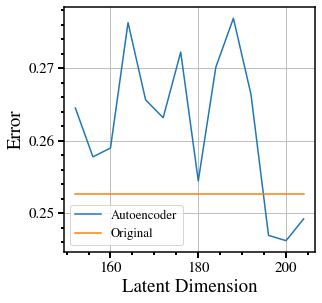

In [83]:
fig, ax = plt.subplots()
ax.plot(n_components, errr, label='Autoencoder')
ax.plot(n_components, np.ones(len(n_components)) * 0.2526, label='Original')
ax.set_xlabel('Latent Dimension')
ax.set_ylabel('Error')
ax.grid()
ax.legend()
format_axis(ax)
plt.savefig('ae.png', bbox_inches='tight', dpi=300)

In [8]:
n_components = np.arange(204, 150, -4)
errr = []
for n in n_components:
    pca = PCA(n_components=n)

    xp = pca.fit_transform(xs)

    x = generate_data(xp.T, window=48)
    xp2 = xs
    x2 = generate_data(xp2.T, window=48)
    # print(xp.shape)

    r = int(0.9*x.shape[-1])

    err, err2 = [], []

    for t in range(len(x) - 1):
        x_o, x_r, _ = dmd(x[t], r)
        x2_o, x2_r, _ = dmd(x2[t], r)

        x_o = x2_o.T
        x_r = x_r.T
        x2_r = x2_r.T
        x_r = pca.inverse_transform(x_r)

        err_ = per_error(x_o, x_r)
        err2_ = per_error(x_o, x2_r)

        err.append(err_)
        err2.append(err2_)
        print(f'{t}', end='\r')
    err = np.array(err)
    err2 = np.array(err2)
    err.sort()
    err2.sort()
    err = err[:-2]
    err2 = err2[:-2]
    errr.append(err.mean())
    print(f'AE: {err.mean():0.4g}+/-{err.std():0.4g}')
    print(f'Ori: {err2.mean():0.4g}+/-{err2.std():0.4g}')

AE: 0.2403+/-0.1544
Ori: 0.2526+/-0.1982
AE: 0.2397+/-0.1478
Ori: 0.2526+/-0.1982
AE: 0.2397+/-0.1457
Ori: 0.2526+/-0.1982
AE: 0.2398+/-0.1451
Ori: 0.2526+/-0.1982
AE: 0.2411+/-0.1476
Ori: 0.2526+/-0.1982


KeyboardInterrupt: 

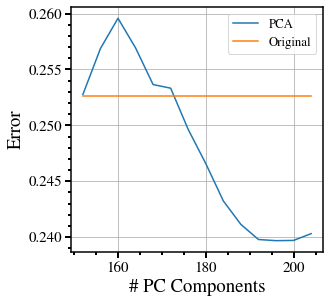

In [34]:
fig, ax = plt.subplots()
ax.plot(n_components, errr, label='PCA')
ax.plot(n_components, np.ones(len(n_components)) * 0.2526, label='Original')
ax.set_xlabel('# PC Components')
ax.set_ylabel('Error')
ax.grid()
ax.legend()
format_axis(ax)
plt.savefig('pca.png', bbox_inches='tight', dpi=300)

In [30]:
pca = PCA(n_components=190)
xp = pca.fit_transform(xs)

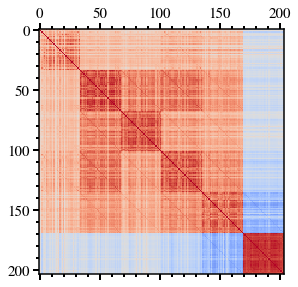

In [29]:
fig, ax = plt.subplots()
mat = np.corrcoef(xs.T)
vmax = np.max(np.abs(mat))
ax.matshow(mat, cmap='coolwarm', vmin=-vmax, vmax=vmax)
format_axis(ax)
plt.savefig('corr.png', bbox_inches='tight', dpi=300)

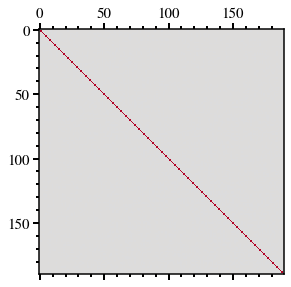

In [31]:
fig, ax = plt.subplots()
mat = np.corrcoef(xp.T)
vmax = np.max(np.abs(mat))
ax.matshow(mat, cmap='coolwarm', vmin=-vmax, vmax=vmax)
format_axis(ax)
plt.savefig('corr_pca.png', bbox_inches='tight', dpi=300)

In [32]:
size=200
x_in = layers.Input(shape=(204, ))
x = layers.Dense(size, activation='selu')(x_in)
x = layers.Dense(204, activation='sigmoid')(x)
model = Model(inputs=x_in, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.load_weights(f'test_{size}.h5')

encoder = Model(model.input, model.layers[-2].output)

decoder_input = layers.Input(shape=(size,))
decoder = Model(decoder_input, model.layers[-1](decoder_input))


xp2 = encoder.predict(xs)

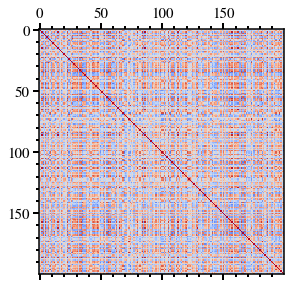

In [39]:
fig, ax = plt.subplots()
mat = np.corrcoef(xp2.T)
vmax = np.max(np.abs(mat))
ax.matshow(mat, cmap='coolwarm', vmin=-vmax, vmax=vmax)
format_axis(ax)
plt.savefig('corr_ae.png', bbox_inches='tight', dpi=300)

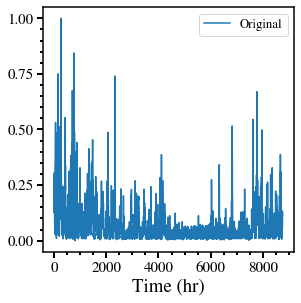

In [40]:
fig, ax = plt.subplots()
ax.plot(xs[:, 0], label='Original')
ax.set_xlabel('Time (hr)')
ax.legend()
format_axis(ax)
plt.savefig('signal.png', bbox_inches='tight', dpi=300)
# ax.plot(xp[:, 0])
# ax.plot(xp2[:, 0])

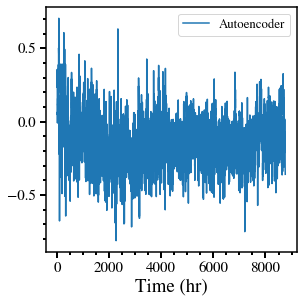

In [42]:
fig, ax = plt.subplots()
ax.plot(xp2[:, 0], label='Autoencoder')
ax.set_xlabel('Time (hr)')
ax.legend()
format_axis(ax)
plt.savefig('signal_ae.png', bbox_inches='tight', dpi=300)
# ax.plot(xp[:, 0])
# ax.plot(xp2[:, 0])

In [ ]:
fig, ax = plt.subplots()
ax.plot(xp[:, 0], label='PCA')
ax.set_xlabel('Time (hr)')
ax.legend()
format_axis(ax)
plt.savefig('signal_pca.png', bbox_inches='tight', dpi=300)
# ax.plot(xp[:, 0])
# ax.plot(xp2[:, 0])

In [390]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [392]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [439]:
latent_dim = 102

encoder_inputs = keras.Input(shape=(204, ))
x = layers.Dense(102, activation="leaky_relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

In [440]:
latent_inputs = keras.Input(shape=(latent_dim,))
decoder_outputs = layers.Dense(204, activation="sigmoid")(latent_inputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

In [441]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [442]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=500, batch_size=128)

Epoch 1/500
69/69 [==============================] - 0s 2ms/step - loss: 88.1628 - reconstruction_loss: 70.1869 - kl_loss: 6.6643
Epoch 2/500
69/69 [==============================] - 0s 2ms/step - loss: 59.9686 - reconstruction_loss: 52.1826 - kl_loss: 6.0437
Epoch 3/500
69/69 [==============================] - 0s 2ms/step - loss: 55.8349 - reconstruction_loss: 49.5737 - kl_loss: 5.3220
Epoch 4/500
69/69 [==============================] - 0s 2ms/step - loss: 54.6171 - reconstruction_loss: 48.9088 - kl_loss: 4.9443
Epoch 5/500
69/69 [==============================] - 0s 2ms/step - loss: 53.1952 - reconstruction_loss: 48.1896 - kl_loss: 4.5630
Epoch 6/500
69/69 [==============================] - 0s 2ms/step - loss: 52.9498 - reconstruction_loss: 47.9571 - kl_loss: 4.4014
Epoch 7/500
69/69 [==============================] - 0s 2ms/step - loss: 52.5820 - reconstruction_loss: 47.8733 - kl_loss: 4.2857
Epoch 8/500
69/69 [==============================] - 0s 2ms/step - loss: 52.4740 - reconst

69/69 [==============================] - 0s 2ms/step - loss: 45.7735 - reconstruction_loss: 44.1618 - kl_loss: 1.2320
Epoch 126/500
69/69 [==============================] - 0s 2ms/step - loss: 45.5404 - reconstruction_loss: 44.1605 - kl_loss: 1.2361
Epoch 127/500
69/69 [==============================] - 0s 2ms/step - loss: 45.7095 - reconstruction_loss: 44.1691 - kl_loss: 1.2354
Epoch 128/500
69/69 [==============================] - 0s 2ms/step - loss: 45.8670 - reconstruction_loss: 44.1576 - kl_loss: 1.2410
Epoch 129/500
69/69 [==============================] - 0s 2ms/step - loss: 45.9203 - reconstruction_loss: 44.1600 - kl_loss: 1.2423
Epoch 130/500
69/69 [==============================] - 0s 2ms/step - loss: 45.5169 - reconstruction_loss: 44.1703 - kl_loss: 1.2373
Epoch 131/500
69/69 [==============================] - 0s 2ms/step - loss: 45.5198 - reconstruction_loss: 44.1690 - kl_loss: 1.2280
Epoch 132/500
69/69 [==============================] - 0s 2ms/step - loss: 45.7008 - recon

69/69 [==============================] - 0s 2ms/step - loss: 45.9289 - reconstruction_loss: 44.1618 - kl_loss: 1.2403
Epoch 250/500
69/69 [==============================] - 0s 2ms/step - loss: 45.6758 - reconstruction_loss: 44.1734 - kl_loss: 1.2244
Epoch 251/500
69/69 [==============================] - 0s 2ms/step - loss: 45.7454 - reconstruction_loss: 44.1603 - kl_loss: 1.2311
Epoch 252/500
69/69 [==============================] - 0s 2ms/step - loss: 45.7722 - reconstruction_loss: 44.1626 - kl_loss: 1.2314
Epoch 253/500
69/69 [==============================] - 0s 2ms/step - loss: 45.8467 - reconstruction_loss: 44.1817 - kl_loss: 1.2350
Epoch 254/500
69/69 [==============================] - 0s 2ms/step - loss: 45.9972 - reconstruction_loss: 44.1678 - kl_loss: 1.2378
Epoch 255/500
69/69 [==============================] - 0s 2ms/step - loss: 45.8253 - reconstruction_loss: 44.1665 - kl_loss: 1.2403
Epoch 256/500
69/69 [==============================] - 0s 2ms/step - loss: 45.6839 - recon

69/69 [==============================] - 0s 2ms/step - loss: 45.7959 - reconstruction_loss: 44.1645 - kl_loss: 1.2256
Epoch 374/500
69/69 [==============================] - 0s 2ms/step - loss: 45.7006 - reconstruction_loss: 44.1645 - kl_loss: 1.2239
Epoch 375/500
69/69 [==============================] - 0s 2ms/step - loss: 45.6170 - reconstruction_loss: 44.1735 - kl_loss: 1.2303
Epoch 376/500
69/69 [==============================] - 0s 2ms/step - loss: 45.8515 - reconstruction_loss: 44.1495 - kl_loss: 1.2513
Epoch 377/500
69/69 [==============================] - 0s 2ms/step - loss: 45.8426 - reconstruction_loss: 44.1654 - kl_loss: 1.2394
Epoch 378/500
69/69 [==============================] - 0s 2ms/step - loss: 45.8907 - reconstruction_loss: 44.1659 - kl_loss: 1.2439
Epoch 379/500
69/69 [==============================] - 0s 2ms/step - loss: 45.9184 - reconstruction_loss: 44.1578 - kl_loss: 1.2337
Epoch 380/500
69/69 [==============================] - 0s 2ms/step - loss: 45.7419 - recon

69/69 [==============================] - 0s 2ms/step - loss: 45.6456 - reconstruction_loss: 44.1669 - kl_loss: 1.2481
Epoch 498/500
69/69 [==============================] - 0s 2ms/step - loss: 45.6836 - reconstruction_loss: 44.1602 - kl_loss: 1.2333
Epoch 499/500
69/69 [==============================] - 0s 2ms/step - loss: 45.8622 - reconstruction_loss: 44.1648 - kl_loss: 1.2346
Epoch 500/500
69/69 [==============================] - 0s 2ms/step - loss: 45.8532 - reconstruction_loss: 44.1561 - kl_loss: 1.2321


In [443]:
x_pred = vae.decoder.predict(vae.encoder.predict(x_train)[0])

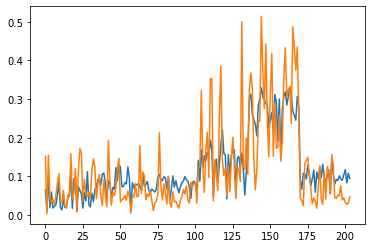

In [444]:
idx = 26
plt.plot(x_pred[idx])
plt.plot(x_train[idx])

In [398]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11501568/11490434 [==============================] - 3s 0us/step


In [399]:
mnist_digits.shape

(70000, 28, 28, 1)

In [291]:
xp = xs
x = generate_data(xp.T, window=48)
print(xp.shape)

r = int(0.9*x.shape[-1])

err = []

for t in range(len(x) - 1):
    if t != 40:
        x_o, x_r, _ = dmd(x[t], r)
        x_o = x_o.T
        x_r = x_r.T

    #     x_o = decoder.predict(x_o)
    #     x_r = decoder.predict(x_r)
        err_ = per_error(x_o, x_r)

        err.append(err_)
        print(f'{t}', end='\r')
err = np.array(err)
print(f'Reconstruction Error: {err.mean():0.4g}+/-{err.std():0.4g}')

(8760, 204)
Reconstruction Error: 0.261+/-0.2272


136


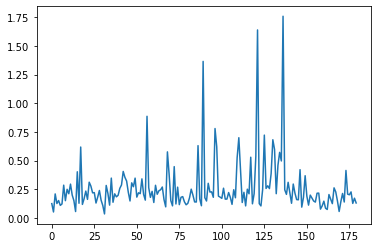

In [292]:
plt.plot(err)
print(np.argmax(err))

In [278]:
x_o, x_r, _ = dmd(x[40], r)
x_o = x_o.T
x_r = x_r.T

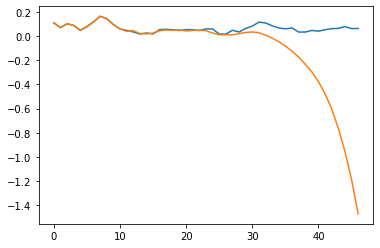

In [284]:
plt.plot(x_o[:, 2])
plt.plot(x_r[:, 2])

feature matrix (8760, 204) = (time, # features)

previously, PCA --> hidden dimension --> DMD with truncation --> inverse transform

tool 
1. can map to a hidden dimension
2. have inverse transform


tool 1: PCA
tool 2: autoencoder

autoencoder

autoencoder --> (204 -> 32) -> 204 (f1)
f1^(-1) 32-->204 

In [11]:
xs.shape

(8760, 204)

In [248]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [253]:
def nn():
    x_in = Input((204, ))
    x = Dense(64, activation='relu')(x_in)
    x = Dense(64, activation='relu')(x)
    x_out = Dense(204, activation='linear')(x)
    model = Model(inputs=x_in, outputs=x_out)
    return model

In [254]:
model = nn()
model.compile(optimizer=Adam(), loss='mse')
mcp = ModelCheckpoint('test.h5', mode='min')
model.fit(xs, xs, epochs=100, batch_size=32, callbacks=[mcp])

Epoch 1/100
274/274 [==============================] - 0s 770us/step - loss: 0.4028
Epoch 2/100
274/274 [==============================] - 0s 828us/step - loss: 0.2173
Epoch 3/100
274/274 [==============================] - 0s 873us/step - loss: 0.1829
Epoch 4/100
274/274 [==============================] - 0s 838us/step - loss: 0.1633
Epoch 5/100
274/274 [==============================] - 0s 802us/step - loss: 0.1489
Epoch 6/100
274/274 [==============================] - 0s 792us/step - loss: 0.1385
Epoch 7/100
274/274 [==============================] - 0s 863us/step - loss: 0.1298
Epoch 8/100
274/274 [==============================] - 0s 806us/step - loss: 0.1219
Epoch 9/100
274/274 [==============================] - 0s 828us/step - loss: 0.1151
Epoch 10/100
274/274 [==============================] - 0s 783us/step - loss: 0.1095
Epoch 11/100
274/274 [==============================] - 0s 829us/step - loss: 0.1043
Epoch 12/100
274/274 [==============================] - 0s 733us/step - lo